# Prelims

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.text import *

import textwrap

/Users/adamschiller/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
PATH = Path('data/IAM_handwriting')
TMP_PATH = PATH/'tmp'
CSV = PATH/'words.csv'

# !ls {PATH}

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Helpers

In [5]:
def nonzero(pred):
    ints = to_np(pred).astype(int)
    return ints[np.nonzero(ints)]

def char_label_text(pred, chunk=70):
    st = ''.join([itos[i] for i in nonzero(pred)])
    return '\n'.join(textwrap.wrap(st, chunk))

def char_split_text(pred):
    return [itos[i] for i in nonzero(pred)]

def word_label_text(pred, chunk=70):
    st = ' '.join([w_itos[i] for i in nonzero(pred)])
    return '\n'.join(textwrap.wrap(st, chunk))

In [6]:
def show_img(im, figsize=None, ax=None, alpha=None, title=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    if title: ax.set_title(title)
    return ax

# Data

## 3x1

In [71]:
fname = 'synth_words_50000.csv' if device.type == 'cuda' else 'synth_words.csv'
CSV = PATH/fname
FOLDER = 'synth_words'

csv = pd.read_csv(CSV)
len(csv)

10000

In [80]:
sz,bs = 256,60  #128,100
seq_len = 45
stats = (np.array([0.90382, 0.90382, 0.90382]), np.array([0.19798, 0.19798, 0.19798]))  # inception_stats

## 3x2

In [140]:
fname = 'multi_synth_words_50000.csv' if device.type == 'cuda' else 'multi_synth_words.csv'
CSV = PATH/fname
FOLDER = 'multi_synth_words'

csv = pd.read_csv(CSV)
len(csv)

10000

In [169]:
sz,bs = 400,45   #256,60
seq_len = 75
stats = (np.array([0.93186, 0.93186, 0.93186]), np.array([0.17579, 0.17579, 0.17579]))

## Large

In [182]:
fname = 'large_synth_words_50000.csv' if device.type == 'cuda' else 'large_synth_words.csv'
CSV = PATH/fname
FOLDER = 'large_synth_words'

csv = pd.read_csv(CSV)
len(csv)

100

In [183]:
sz,bs = 512,30   #400,45 
seq_len = 250
stats = (np.array([0.93186, 0.93186, 0.93186]), np.array([0.17579, 0.17579, 0.17579]))

## Paragraphs

In [7]:
CSV = PATH/'paragraph_chars.csv'
FOLDER = 'paragraphs'

csv = pd.read_csv(CSV)
len(csv)

1539

In [8]:
sz,bs = 512,30   #800,10    #~2000x1000 full size
seq_len = 500   #~400 chars/paragraph - max: 705
stats = (np.array([0.94161, 0.94161, 0.94161]), np.array([0.12835, 0.12835, 0.12835]))

## ModelData

In [184]:
itos = pickle.load(open(TMP_PATH/'char_itos.pkl', 'rb'))

val_idxs = np.array(csv.sample(frac=0.15, random_state=42).index)

f = resnet34

In [185]:
aug_tfms = [RandomRotate(3, mode=1), RandomLighting(0.05, 0.05)]
# tfms = tfms_from_model(f, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
data = ImageClassifierData.from_csv(PATH, FOLDER, CSV, bs=bs, val_idxs=val_idxs, tfms=tfms, continuous=True)

In [186]:
# pad ends of lines with pad token for language model
data.aug_dl.pre_pad=False
data.trn_dl.pre_pad=False
data.val_dl.pre_pad=False

## Verify Data

In [187]:
denorm = data.trn_ds.denorm
x,y = next(iter(data.trn_dl))
imgs = denorm(x)

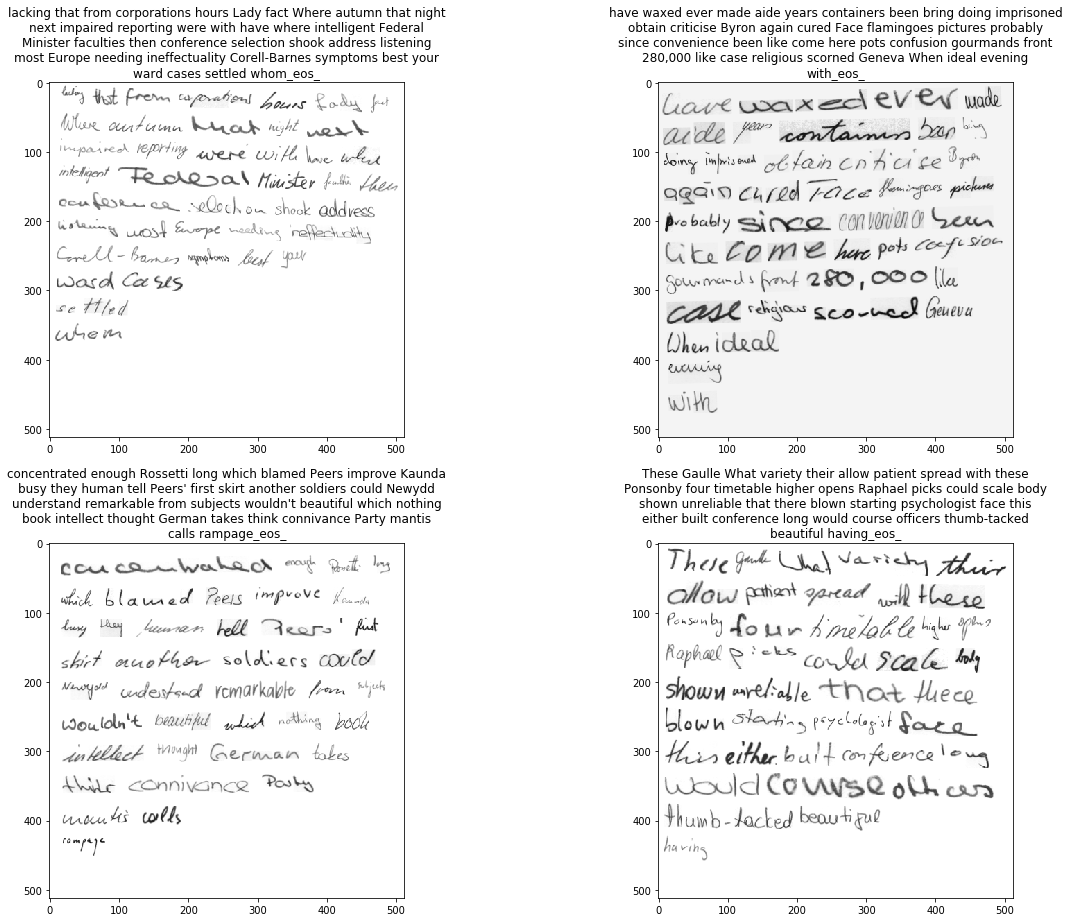

In [188]:
fig, axes = plt.subplots(2,2, gridspec_kw={'hspace': 0.3}, figsize=(20, 15))
for i,ax in enumerate(axes.flat):
    t = char_label_text(y[i])
    ax=show_img(imgs[i], ax=ax, title=t)
    
# plt.tight_layout(pad=0.1)

# Loss and Metrics

In [12]:
def loss_prep(input, target):
    "equalize input/target sl; combine bs/sl dimensions"
    bs,tsl = target.shape
    _ ,sl,vocab = input.shape
        
    # F.pad( front,back for dimensions: 1,0,2 )
    if sl>tsl: target = F.pad(target, (0,sl-tsl))
    if tsl>sl: target = target[:,:sl]
#     if tsl>sl: input = F.pad(input, (0,0,0,0,0,tsl-sl))
        
    targ = target.contiguous().view(-1).long()
    pred = input.contiguous().view(-1, vocab)
    return pred, targ

In [13]:
class LabelSmoothing(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothing, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        
    def forward(self, pred, target):
        pred,targ = loss_prep(pred, target)
        pred = F.log_softmax(pred, dim=-1)  # need this for KLDivLoss
        true_dist = pred.data.clone()
        true_dist.fill_(self.smoothing / pred.size(1))                  # fill with 0.0012
        true_dist.scatter_(1, targ.data.unsqueeze(1), self.confidence)  # [0.0012, 0.0012, 0.90, 0.0012]
        return F.kl_div(pred, true_dist, reduction='sum')/bs

In [14]:
def XE_loss(input, target):    # takes logits
    pred,targ = loss_prep(input, target)
    return F.cross_entropy(pred, targ, reduction='sum')/bs

In [15]:
def perplexity(input, target):
    pred,targ = loss_prep(input, target)
    return np.exp(F.cross_entropy(pred, targ))

In [16]:
def Focal_loss(input, target):
    pred,targ = loss_prep(input, target)
    wgt = get_weight(pred, targ)
    wgt = wgt.mean(0).detach()   # This seems naively logical but probably a terrible idea... 
    return F.cross_entropy(pred, targ, weight=wgt, reduction='sum')/bs
    
def get_weight(p,t):
    t = one_hot_encode(p,t)
    alpha,gamma = 0.25,1
    p = p.sigmoid()
    pt = p*t + (1-p)*(1-t)
    w = alpha*t + (1-alpha)*(1-t)
    return w * (1-pt).pow(gamma)

def one_hot_encode(p,t):
    hot = torch.zeros_like(p)
    return hot.scatter_(1, t.data.unsqueeze(1), 1)

In [17]:
import Levenshtein as Lev

# pulled from Sean Nareen's deepspeech decoder module
# https://github.com/SeanNaren/deepspeech.pytorch/blob/master/decoder.py

def cer(t, p):
    """
    Computes the Character Error Rate, defined as the edit distance.
    Arguments:
        t (string): target space-separated sentence
        p (string): prediction space-separated sentence
    """
    t, p, = t.replace(' ', ''), p.replace(' ', '')
    return Lev.distance(t, p)/len(t)

def wer(s1, s2):
    """
    Computes the Word Error Rate, defined as the edit distance between the
    two provided sentences after tokenizing to words.
    Arguments:
        s1 (string): space-separated sentence
        s2 (string): space-separated sentence
    """

    # build mapping of words to integers
    b = set(s1.split() + s2.split())
    word2char = dict(zip(b, range(len(b))))

    # map the words to a char array (Levenshtein package only accepts strings)
    w1 = [chr(word2char[w]) for w in s1.split()]
    w2 = [chr(word2char[w]) for w in s2.split()]

    return Lev.distance(''.join(w1), ''.join(w2))/len(w1)

In [18]:
def char_error_rate(preds, targs):
    bs,sl = targs.size()      #=> ([bs, sl])
    # preds.size()            #=> ([bs, sl, vs])
        
    res = torch.argmax(preds, dim=2)
    error = 0
    for i in range(bs):
        p = char_label_text(res[i])
        t = char_label_text(targs[i])
        error += cer(t,p)
    return error/bs

def word_error_rate(preds, targs):
    bs,sl = targs.size()      #=> ([bs, sl])
    # preds.size()            #=> ([bs, sl, vs])
        
    res = torch.argmax(preds, dim=2)
    error = 0
    for i in range(bs):
        p = word_label_text(res[i])
        t = word_label_text(targs[i])
        error += wer(t,p)
    return error/bs

# Transformer Architecture

In [19]:
# similar to batchnorm but on a layer level
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [20]:
class SublayerConnection(nn.Module):
    "A residual connection followed by a layer norm.  Note: (for code simplicity) norm is first."
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

In [21]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [22]:
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)

In [23]:
class EncoderLayer(nn.Module):
    "Encoder: self-attn and feed forward"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)

    def forward(self, x):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x))
        return self.sublayer[1](x, self.feed_forward)

In [24]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, src, tgt_mask=None):
        for layer in self.layers:
            x = layer(x, src, tgt_mask)
        return self.norm(x)

In [25]:
class DecoderLayer(nn.Module):
    "Decoder: self-attn, src-attn, and feed forward"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)  # wraps layer in residual,dropout,norm
 
    def forward(self, x, src, tgt_mask=None):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, src, src))
        return self.sublayer[2](x, self.feed_forward)

In [26]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    depth = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(depth)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)    
    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [27]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.2):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, q, k, v, mask=None):
        if mask is not None: mask = mask.unsqueeze(1)
        bs = q.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        q, k, v = [l(x).view(bs, -1, self.h, self.d_k).transpose(1, 2) for l, x in zip(self.linears, (q, k, v))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(q, k, v, mask=mask, dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous().view(bs, -1, self.h * self.d_k)
        return self.linears[-1](x)

In [28]:
class SingleHeadedAttention(nn.Module):
    def __init__(self, d_model, dropout=0.2):
        super(SingleHeadedAttention, self).__init__()
        self.linears = clones(nn.Linear(d_model, d_model), 3)
        self.attn = None
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, query, key, value, mask=None):        
        query, key, value = [l(x) for l, x in zip(self.linears, (query, key, value))]
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        return x

In [29]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, dropout=0.2):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_model*2)  # CHANGES 4 -> 2
        self.w_2 = nn.Linear(d_model*2, d_model)  # CHANGES 4 -> 2
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.leaky_relu(self.w_1(x))))  # CHANGES relu -> leaky_relu

In [30]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0.0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0.0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)
    
# class Embeddings(nn.Module):
#     def __init__(self, d_model, vocab):
#         super(Embeddings, self).__init__()
#         self.lut = nn.Embedding(vocab, d_model)
#         self.d_model = d_model

#     def forward(self, x):
#         return self.lut(x) * math.sqrt(self.d_model)

In [31]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, tgt_mask=None):
        return self.decode(self.encode(src), tgt, tgt_mask)
    
    def encode(self, src):
        return self.encoder(src)
    
    def decode(self, src, tgt, tgt_mask=None):
        return self.decoder(self.tgt_embed(tgt), src, tgt_mask)
    
    def generate(self, outs):
        return self.generator(outs)

# Stepper

In [32]:
def subsequent_mask(size):
    attn_shape = torch.ones((size,size), dtype=torch.uint8, device=device)
    mask = torch.tril(attn_shape).unsqueeze(0)
    return mask

def make_tgt_mask(tgt, pad=0):
    "Create a mask to hide padding and future words."
    tgt_mask = (tgt != pad).unsqueeze(-2)
    tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
    return tgt_mask

In [33]:
def rshift(tgt, token=1):
    "Shift y to the right by prepending token"
    return torch.cat((torch.ones((tgt.size(0),token), device=device), tgt[:,:-1]), dim=-1)

In [34]:
class TfmrStepper(Stepper):
    def step(self, xs, y, epoch):
#         self.m.pr_force = (10-epoch)*0.1 if epoch<10 else 0
        xtra = []
    
        # without BOS token:
        shifted_y = rshift(y).long()
        tgt_mask = subsequent_mask(shifted_y.size(-1)) #make_tgt_mask(shifted_y)
        output = self.m(*xs, shifted_y, tgt_mask)
        
        if isinstance(output,tuple): output,*xtra = output
        self.opt.zero_grad()
        loss = raw_loss = self.crit(output, y)
        if self.reg_fn: loss = self.reg_fn(output, xtra, raw_loss)
        loss.backward()        
        if self.clip:   # Gradient clipping
            nn.utils.clip_grad_norm_(trainable_params_(self.m), self.clip)
        self.opt.step()
        return raw_loss.item()
    
    def evaluate(self, xs, y):
        shifted_y = rshift(y).long()
        tgt_mask = subsequent_mask(shifted_y.size(-1)) #make_tgt_mask(shifted_y)
        preds = self.m(*xs, shifted_y, tgt_mask)
        if isinstance(preds,tuple): preds=preds[0]
        return preds, self.crit(preds, y)

# Img2seq Arch

In [35]:
class ResnetBase(nn.Module):
    def __init__(self, em_sz, d_model):
        super().__init__()
        
        slices = {128: -4, 256: -3, 512: -2}
        s = slices[em_sz]
        net = f(True)
        modules = list(net.children())[:s]
        self.base = nn.Sequential(*modules)
        self.linear = nn.Linear(em_sz, d_model)
        
    def forward(self, img):
        x = self.base(img).flatten(2,3).transpose(2,1)
        return self.linear(x) * math.sqrt(x.size(-1))        # bs,area,d_model

In [36]:
def make_custom_model(vocab, d_model=512, N=2, h=1, drops={'attn':0.2, 'ff':0.2, 'pos':0.1, 'layer':0.3}):
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model, drops['attn'])
#     attn = SingleHeadedAttention(d_model)
    ff = PositionwiseFeedForward(d_model, drops['ff'])
    position = PositionalEncoding(d_model, drops['pos'])
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), drops['layer']), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), drops['layer']), N),
        nn.Sequential(nn.Embedding(vocab, d_model), position),
        #nn.Sequential(Embeddings(d_model, vocab), position),
        nn.Linear(d_model, vocab)
    )
        
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
            #nn.init.kaiming_normal_(p)  # better for use w/ relu activations
            # the resnet base is initialized w/ kaiming_normal
                    
    return model

In [37]:
class Img2Seq(nn.Module):
    def __init__(self, img_encoder, transformer):
        super(Img2Seq, self).__init__()
        self.img_enc = img_encoder
        self.transformer = transformer
        
    def forward(self, src, tgt=None, tgt_mask=None):
        feats = self.img_enc(src)                            # ([bs, h*w, em_sz])        
        dec_outs = self.transformer(feats, tgt, tgt_mask)    # ([bs, sl, d_model])
        out = self.transformer.generate(dec_outs)            # ([bs, sl, vocab])
        return out

    def greedy_decode(self, src, seq_len):
        with torch.no_grad():
            feats = self.img_enc(src)
            bs = src.size(0)
            tgt = torch.ones((bs,1), dtype=torch.long, device=device)

            res = []                
            for i in tqdm(range(seq_len)):
                dec_outs = self.transformer(feats, Variable(tgt))
                prob = self.transformer.generate(dec_outs[:,-1])
                res.append(prob)
                pred = torch.argmax(prob, dim=-1, keepdim=True)
                if (pred==0).all(): break
                tgt = torch.cat([tgt,pred], dim=-1)
            out = torch.stack(res).transpose(1,0).contiguous()
            return out

In [83]:
d_model = 512
em_sz = 256 #128 if device.type == 'cpu' else 256
img_encoder = ResnetBase(em_sz, d_model)
transformer = make_custom_model(len(itos), d_model)
net = Img2Seq(img_encoder, transformer)

opt_fn = partial(optim.Adam, betas=(0.7, 0.99)) #, lr=0, betas=(0.9, 0.98), eps=1e-9)
# model_opt = NoamOpt(d_model, 2, 400, optim.Adam(net.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
# steps: [1e-5, 2e-5, 3e-5, 4e-5... Ne-4]

learn = RNN_Learner(data, SingleModel(to_gpu(net)), opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = XE_loss #LabelSmoothing(smoothing=0.1)   #XE_loss  #Focal_loss
learn.metrics = [char_error_rate]

# Train

### load state dict for changes

In [85]:
sd = torch.load(PATH/'models'/'tfmr_paragraph.h5', map_location=lambda storage, loc: storage)

In [78]:
sd.pop('img_enc.linear.bias')   # need to remove mismatched linear weight

tensor([-0.0339,  0.0369,  0.0429,  0.0000, -0.0198, -0.0293,  0.0288,  0.0490,
        -0.0303, -0.0415,  0.0184,  0.0527,  0.0322, -0.0581, -0.0493,  0.0425,
        -0.0194, -0.0407,  0.0243, -0.0465, -0.0298,  0.0616,  0.0551,  0.0073,
         0.0286, -0.0051, -0.0411,  0.0063, -0.0160,  0.0192,  0.0349,  0.0445,
         0.0560,  0.0577,  0.0356, -0.0498,  0.0571,  0.0054,  0.0317, -0.0209,
        -0.0259,  0.0265, -0.0152,  0.0359, -0.0421,  0.0623,  0.0123, -0.0527,
         0.0392, -0.0311, -0.0215, -0.0348, -0.0314, -0.0439,  0.0543,  0.0438,
         0.0430,  0.0557, -0.0076, -0.0606,  0.0370, -0.0542,  0.0028, -0.0079,
         0.0170, -0.0332, -0.0427, -0.0378, -0.0237,  0.0175, -0.0618,  0.0533,
        -0.0602,  0.0301,  0.0564, -0.0046,  0.0106, -0.0213, -0.0015, -0.0398,
        -0.0157,  0.0106,  0.0361,  0.0315,  0.0588,  0.0416, -0.0026,  0.0048,
        -0.0007, -0.0588, -0.0167,  0.0540,  0.0391, -0.0512,  0.0549,  0.0088,
         0.0049,  0.0618,  0.0445, -0.02

In [86]:
learn.model.load_state_dict(sd, strict=False)

### load model

In [39]:
learn.load('tfmr_lg2')

## LR find

 53%|█████▎    | 70/131 [01:26<01:15,  1.24s/it, loss=1.12e+03]

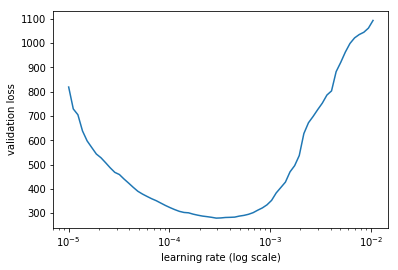

In [39]:
learn.lr_find(stepper=TfmrStepper)
learn.sched.plot(n_skip=0, n_skip_end=2)

## Experimentation

In [ ]:
#gpu
lr=1e-4
learn.fit(lr, 5, cycle_len=1, stepper=TfmrStepper, use_clr=(20,5))
# 3x1: XE/bs, kaiming_normal, no pos_enc, emb/out weight tying, no encoder, 2 layers, 256/256, single attn
# 52.199187  50.1736    0.730092    lr:1e-4
# 17.318725  13.803769  0.205331    2nd run, lr: 1e-3
# 11.96539   9.991971   0.151522    3rd run, lr: 1e-4     **tfmr

# Loss fns
# 43.177135  41.245482  1.185836    LabelSmoothing (KL/bs)
# 4215.8745  4012.3099  0.957795    LabelSmoothing (KL)
# 45.200728  43.662235  0.753881    LabelSmoothing (KL/bs w/out padding logic)  perplexity < BLEU/acc
# 5340.5770  5129.8346  0.738853    XE                    --- scaling by BS not a factor
# 52.199187  50.1736    0.730092    XE/bs  **

# Initialization/Activation
# 52.199187  50.1736    0.730092    kaiming_normal  (ff activation: leaky_relu)
# 52.987157  50.976083  0.758013    kaiming_uniform
# 49.553779  47.270616  0.702353    xavier_normal
# 49.380884  47.345175  0.673508    xavier_uniform  (ff activation: leaky_relu)   **
# 49.849071  47.369221  0.708807    xavier_uniform  (ff activation: relu)

# Positional Encoding
# 35.426869  30.449724  0.423573    target only; no embed/out weight tying   **
# 35.390268  31.216677  0.45097     "" ; w/ scaling factor [* math.sqrt(d_model)]
# 45.596748  42.213515  0.572662    target only; w/ embed/out weight tying

# Encoder
# 34.46771   29.207974  0.408425    **

# Attention
# 32.087941  26.431674  0.362717    SingleHead - linear layers for (q,k,v)
# 37.739475  32.962685  0.454753    MultiHead (8)
# 36.09057   31.346036  0.432342    MultiHead (4)
# 31.069687  26.00539   0.360032    MultiHead (1)     **

#####  x + self.dropout(sublayer(self.norm(x)))   #####
# Positional Encoding 2d (src)
# 31.474786  25.489892  0.34848     Baseline (linear)                  ~10m  **
# 34.688758  28.199628  0.389828    Baseline (conv2d)                  ~10m
# 35.69547   28.730935  0.406246    PositionalEncoding2d (sinusoidal)  ~10m
# 34.305948  28.124971  0.3877      PositionalEmbedding2d (learned)    ~10m

# MLP - generator   *** x + self.dropout(sublayer(self.norm(x))) ***
# 38.642422  32.88599   0.451587
##### --- ######

# N layers (6)
# 51.119606  48.809905  0.645302

# d_model = 512
# 21.032752  17.234559  0.230763    ~11:35  **

# em_sz
# 27.589121  22.698359  0.307399    128  ~14:09
# 28.320952  24.183105  0.338207    512  ~11:31

# include layer_norm in encoder/decoder
# 24.035412  19.824303  0.270881   modified: self.norm(x + self.dropout(sublayer(x)))
# 20.347157  17.23408   0.228328   original:  x + self.dropout(sublayer(self.norm(x)))   **tfmr_experiment
# 10.732795  9.875141   0.12633    2nd run

In [52]:
learn.save('tfmr_experiment')

## Initial size

In [38]:
learn.load('tfmr_3x2')

In [87]:
lr=1e-4
learn.fit(lr, 5, cycle_len=1, stepper=TfmrStepper, use_clr=(20,5))
# 3x1, sz: 128, bs: 100
# 20.347157  17.23408   0.228328
# 10.732795  9.875141   0.12633     2nd run

# 3x2; sz: 256, bs: 60
# 14.65408   13.10881   0.090017    preload tfmr_3x1_256

# lg; sz: 400, bs: 30
# 98.491235  89.396089  0.123849    preload tfmr_3x2      'tfmr_lg'
# 101.903571 88.239827  0.122516    -same as above-       'tfmr_lg2'
# 161.90945  169.713365 0.207615    bs:45, dropout:0.5    'tfmr_lg_tmp'

# paragraph; sz:512, bs:30
# 289.464371 202.553455 0.175994     preload tfmr_lg2, 4 cycles
# 178.432805 145.702918 0.128241     2nd run, 5 cycles
# 144.489454 130.875442 0.116076     3rd run              'tfmr_paragraph'


# 838.60848  764.140503 0.686669     preload tfmr_paragraph (remove img_enc.linear), em_sz > 512   'tfmr_pg_512'
#      preload tfmr_paragraph, layers > 3   !!CUDA error

 84%|████████▍ | 37/44 [01:42<00:19,  2.77s/it, loss=144]

RuntimeError: CUDA error: out of memory

In [82]:
learn.save('tfmr_pg_512')

## Increase size

In [42]:
sz,bs = 800,10

In [47]:
learn.set_data(data)

In [40]:
lr=1e-4
learn.fit(lr, 5, cycle_len=1, stepper=TfmrStepper, use_clr=(20,5))
# 3x1; sz: 256, bs: 60
# 8.169301   7.199782   0.087933    fresh start
# 4.305115   4.585243   0.054132    2nd run (increase dropout 0.2)      'tfmr_3x1_256'

# 3.6729     3.756866   0.047393    resize from 128

# 3x2; sz: 400, bs: ?
# 5.701717   5.83973    0.039572    resize from 256 (increase dropout 0.3)     'tfmr_3x2'

# lg; sz: 512, bs: 30
# 38.786294  45.805161  0.061061    resize from 400  -quit after 3 epochs-

# preload tfmr_lg2; increase dropout to 0.3 in attention and ff; wd; lower lr
# 98.273312  60.214675  0.08372    lr: 1.5e-5, wd: 1e-5, 3 cycles(20,4)                    'tfmr_lg_wd'
# 81.961758  53.715966  0.075622   lr: 2e-5, no wd, 4 cycles(20,5)  -quit after 2 epochs-  'tfmr_lg_wd_tmp'
# 45.696747  37.355512  0.053213   "", {drops}, preloaded tfmr_lg_wd_tmp                   'tfmr_lg2'

# paragraph; sz:800, bs:10
# 100.395217 86.058532  0.074781     resize from 512
# 78.234521  81.089716  0.067993     2nd run           'tfmr_paragraph_800'

epoch      trn_loss   val_loss   char_error_rate            
    0      92.896439  83.162403  0.073083  
    1      87.558019  83.821247  0.071323                   
    2      84.205173  81.72018   0.069308                   
    3      79.411103  81.129266  0.068208                   
    4      78.234521  81.089716  0.067993                   



[81.08971585830052, 0.06799254542137165]

In [41]:
learn.save('tfmr_paragraph_800')

# Test

In [39]:
from scipy.ndimage import gaussian_filter
k=16

def torch_scale_attns(attns):
    bs,sl,hw = attns.shape
    num = int(math.sqrt(hw))   # sz // k
    mod = attns.view(bs,sl,num,num)
    scaled = F.interpolate(mod, size=sz)
    return scaled  #([bs, sl, h, w])

def g_filter(att):
    return gaussian_filter(att, sigma=k)

In [40]:
def source_attn(layer=-1): return learn.model.transformer.decoder.layers[layer].src_attn.attn.data
def self_attn(layer=-1): return learn.model.transformer.decoder.layers[layer].self_attn.attn.data

In [189]:
learn.load('tfmr_lg2')

## Validation Results

In [45]:
x,y = next(iter(data.val_dl))

shifted_y = rshift(y).long()
tgt_mask = subsequent_mask(shifted_y.size(-1)) #make_tgt_mask(shifted_y)

learn.model.eval()
preds = learn.model(x, shifted_y, tgt_mask)
res = torch.argmax(preds, dim=-1)

In [46]:
learn.crit(preds, y)
# lg 512: 27.19
# pg 800: 58.760

tensor(64.1993, grad_fn=<DivBackward0>)

In [47]:
char_error_rate(preds, y)
# lg 512: 0.047
# pg 800: 0.053

0.7526848000623522

### Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


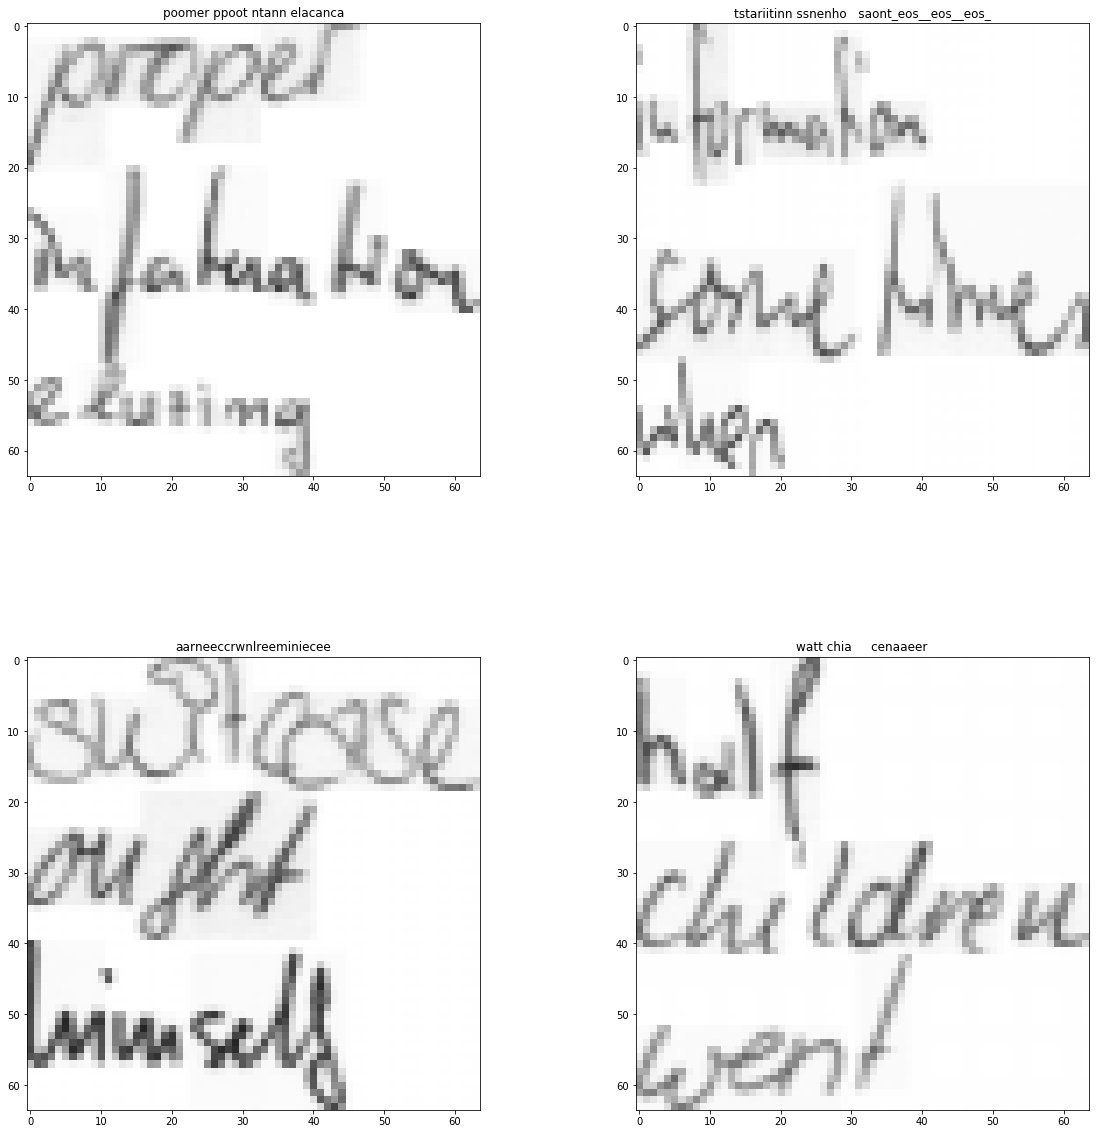

In [48]:
imgs = data.val_ds.denorm(x)

fig, axes = plt.subplots(2,2, gridspec_kw={'hspace': 0.4}, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
    p = char_label_text(res[i])
    ax=show_img(imgs[i], ax=ax, title=p)
    
# plt.tight_layout(pad=0.1)

### Source Attn

In [49]:
src_attn = source_attn().squeeze(1)
src_attn.shape

In [48]:
idx = 2
img = imgs[idx]
pred = res[idx]
img_attns = to_np(torch_scale_attns(src_attn[idx-1:idx])[0])

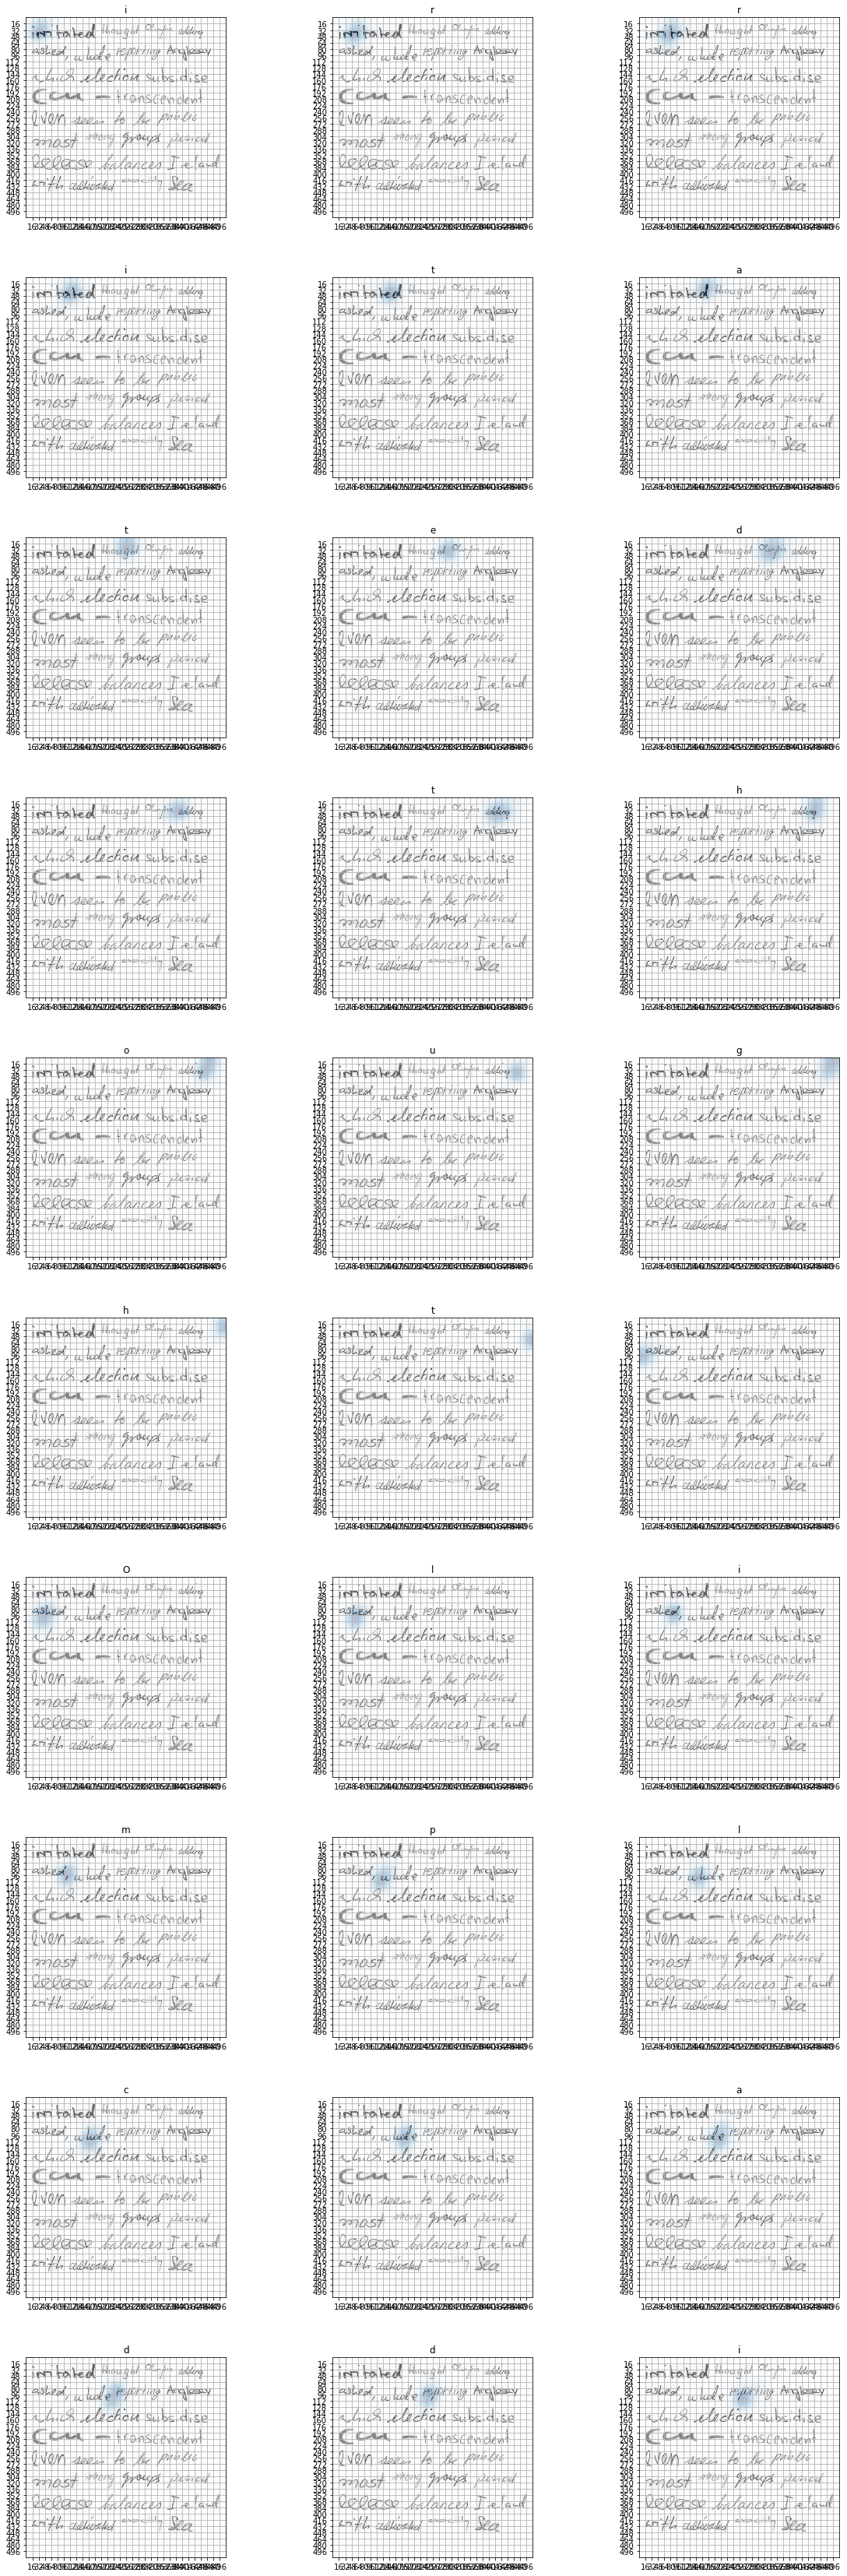

In [49]:
fig, axes = plt.subplots(10,3, gridspec_kw={'hspace': 0.3}, figsize=(20, 60))
for i,ax in enumerate(axes.flat):
    a = g_filter(img_attns[i])
    ax.imshow(img, alpha=None)
    ax.imshow(a, cmap='Blues', interpolation='nearest', alpha=0.3)
    
    # Attention
    ticks = np.arange(k, sz, k)
    ax.set_yticks(ticks, minor=False)
    ax.set_xticks(ticks, minor=False)
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)

    ax.set_title(itos[pred[i].item()])

### Target (self) Attn

Decoder Self Layer 1


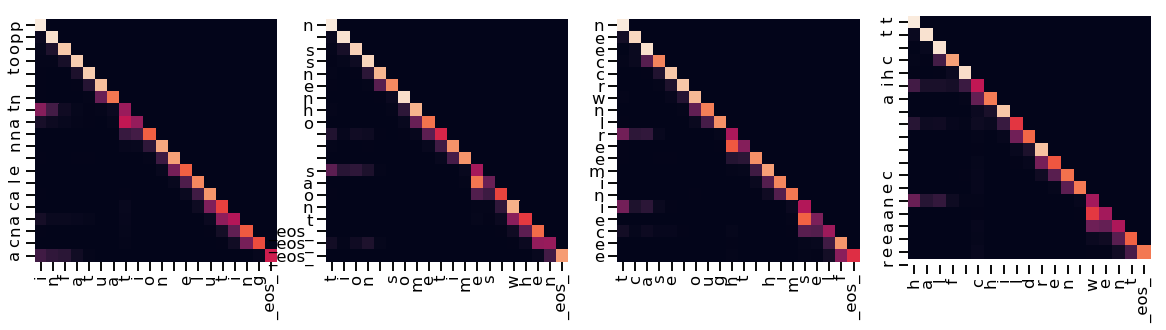

Decoder Self Layer 2


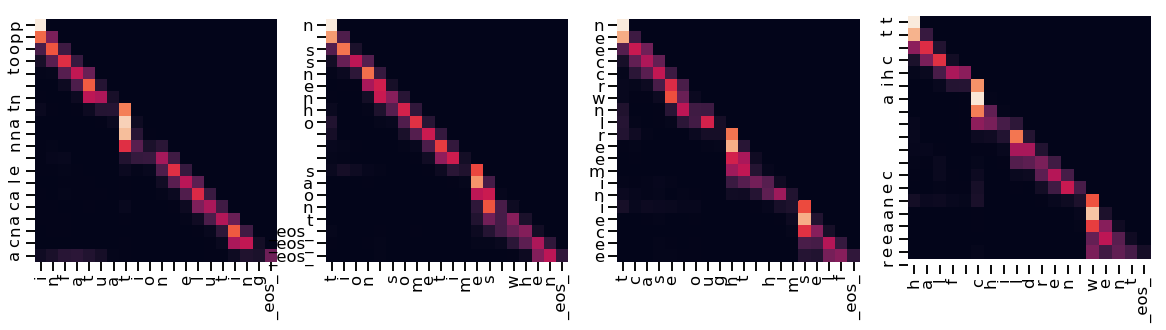

In [50]:
sns.set_context(context="talk")

def draw(data, x, y, ax):
    sns.heatmap(data, xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, cbar=False, ax=ax)

h = 0  #attn head
for layer in range(2):
    print("Decoder Self Layer", layer+1)
    fig, axes = plt.subplots(1,4, figsize=(20, 10))
    for i,ax in enumerate(axes.flat):  # multi example
        pred = char_split_text(res[i])[-20:]   # only last 20
        true = char_split_text(y[i])[-20:]     # only last 20
        draw(self_attn(layer)[i,h].data[:len(true), :len(true)], true, pred, ax=ax)
    plt.show()

### word attn

In [67]:
char_attn = src_attn.squeeze(1)
chars = pred.cpu().numpy()

In [86]:
arr = nonzero(chars)[:-1]         # remove zeros and eos char
ones = np.where(arr == 1)[0]+1    # find idxs of 1s and adds 1 (prepend 1 later on)
idxs = np.where(arr != 1)[0]
words = np.split(np.insert(arr, 0, 1), ones)   # prepend 1 to arr, split on ones
words = [w[1:] for w in words]    # remove all of the initial 1s

array([42, 73, 74,  1, 42, 56, 73, 67, 60, 56, 59,  1, 75, 63, 70, 76, 62, 63, 75,  1, 75, 63, 60,  1, 75,
       78, 70,  1, 47, 63, 70, 59, 60, 74, 64, 56, 69,  1, 71, 56, 73, 75, 64, 60, 74,  1, 63, 56, 59,  1,
       73, 60, 61, 76, 73, 60, 59,  1, 75, 70,  1, 56, 75, 60, 60, 69, 59,  1, 75, 63, 60,  1, 75, 56, 67,
       66, 74,  1, 57, 60, 58, 56, 76, 74, 60,  1, 48, 64, 73,  1, 75, 70, 80,  1, 63, 56, 59,  1, 61, 70,
       76, 69, 59,  1, 68, 60, 74, 74, 56, 62, 60, 74,  1, 74, 60, 69, 75,  1, 61, 73, 70, 68,  1, 75, 63,
       60,  1, 36, 70, 77, 60, 73, 69, 68, 60, 69, 75,  1, 78, 60, 73, 60,  1, 64, 76, 76, 69, 74, 56, 75,
       64, 74, 61, 56, 58, 14,  1, 75, 70, 73, 80,  1, 15,  1, 30,  1, 30, 61, 73, 64, 58, 56, 69,  1, 59,
       60, 67, 60, 62, 70, 75, 60, 74,  1, 75, 70,  1, 75, 63, 60,  1, 75, 56, 67, 66, 74,  1, 80, 60, 74,
       75, 60, 73, 14,  1, 75, 56, 80,  1, 58, 56, 67, 67, 60, 59,  1, 70, 69,  1, 42, 73, 15,  1, 42, 56,
       58, 68, 64, 67, 56, 56, 69,  1

In [108]:
[''.join(itos[c] for c in w) for w in words]

['Mrs',
 'Marlead',
 'thought',
 'the',
 'two',
 'Rhodesian',
 'parties',
 'had',
 'refured',
 'to',
 'ateend',
 'the',
 'talks',
 'because',
 'Sir',
 'toy',
 'had',
 'found',
 'messages',
 'sent',
 'from',
 'the',
 'Government',
 'were',
 'iuunsatisfac-',
 'tory',
 '.',
 'A',
 'African',
 'delegotes',
 'to',
 'the',
 'talks',
 'yester-',
 'tay',
 'called',
 'on',
 'Mr.',
 'Macmilaan',
 'to',
 'cease',
 'his',
 'degotiations',
 'with',
 'Iis',
 "tay's",
 'representative',
 ',',
 'Mr.',
 'Iulius',
 'treenfield',
 ',',
 'He',
 'was',
 'at',
 'Che-',
 'quers',
 'last',
 'wee--end',
 '.',
 'They',
 'said',
 'they',
 'reganded',
 'with',
 ',',
 'growing',
 'anger',
 ',',
 'the',
 'r',
 'aross',
 'and',
 'unconstitutional',
 'iiinterference',
 'by',
 'sir',
 "Roy's",
 'Federal',
 'Government',
 'in',
 'the',
 'thlls',
 't']

## Decoding

In [190]:
x,y = next(iter(data.val_dl))
inp,targ = x[:10],y[:10]  #x[-1:],y[-1:]

In [124]:
def beam_search(net, inp, seq_len, k=5):
    with torch.no_grad():
        #bs = inp.size(0)
        feats = net.img_enc(inp)
        feats = feats.expand(k,-1,-1)    # expand tensor to bs*k 
        
        tgt = torch.ones((k,seq_len), dtype=torch.long, device=device)
        tgt_mask = subsequent_mask(tgt.size(-1))
        
        beam = torch.ones((k,1), device=device)
                
        res = []
        for i in tqdm(range(seq_len-1)):
            dec_outs = net.transformer(feats, tgt, tgt_mask)
            logits = net.transformer.generate(dec_outs[:,i])
            res.append(logits)
            probs,preds = torch.topk(F.softmax(logits, -1), k, dim=-1)  # (k, k)
            
            if (preds[:,0]==0).all(): break
            
            if i==0:    # first seq only
                beam = probs[0].unsqueeze(1)
                tgt[:,i+1] = preds[0]
            else:
                v,idxs = (beam*probs).flatten().topk(5)  #k*k
                beam = v.unsqueeze(1)

                current_tgt = tgt[:,:i+1].clone()
                for ii,idx in enumerate(idxs):
                    row,col = idx//k,idx%k   # row: beam of previous sequence,  col: current prediction
                    targ = torch.cat([current_tgt[row],preds[row,col][None]])
                    tgt[ii,:i+2] = targ

        out = torch.stack(res).transpose(1,0).contiguous()
        return out[0][None], tgt[0, 1:]

In [125]:
#beam
learn.model.eval()
g_preds, g_res = beam_search(learn.model, inp, seq_len)

 34%|███▍      | 15/44 [00:02<00:04,  6.11it/s]


In [191]:
#greedy
learn.model.eval()
g_preds = learn.model.greedy_decode(inp, seq_len)
g_res = torch.argmax(g_preds, dim=-1)

100%|██████████| 250/250 [05:53<00:00,  1.60s/it]


In [192]:
learn.crit(g_preds, targ)
# bs: 10
# 3x1 256: 8.4938
#    full: 
# 3x2 400: 37.0029, 47.2525
#    full:
# lg 512: 772.5972, 776.4949   ~6m
# pg 512: 68.66
# pg 800: 445.51

tensor(776.4949)

In [193]:
char_error_rate(g_preds, targ)
# 3x1 256: 0.0230
#    full:
# 3x2 400: 0.0379, 0.1551
#    full:
# lg 512: 0.1003, 0.1768
# pg 512: 0.055
# pg 800: 0.252

0.1768939691692464

In [194]:
perplexity(g_preds,targ)
# 3x1 256: 5.7970
#    full:
# 3x2 400: 29.9109, 51.3009
#    full:

tensor(11135.9941)

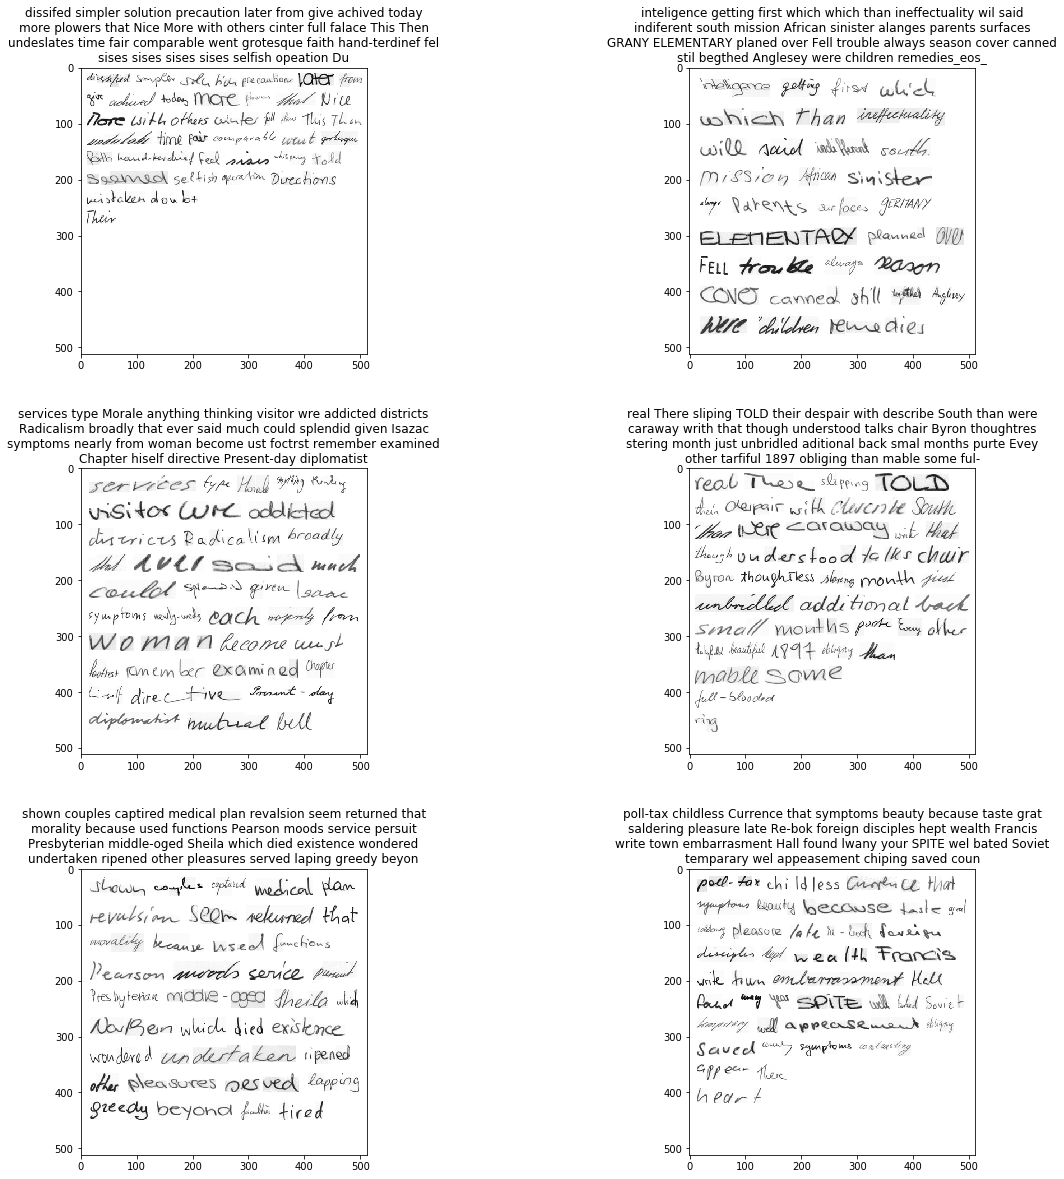

In [196]:
#greedy
imgs = data.val_ds.denorm(inp)

fig, axes = plt.subplots(3,2, gridspec_kw={'hspace': 0.4}, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
    p = char_label_text(g_res[i])
    ax=show_img(imgs[i], ax=ax, title=p)

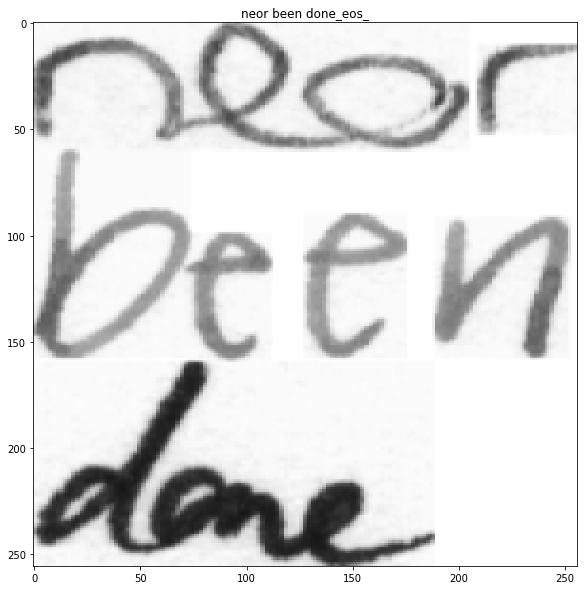

In [131]:
#beam search
img = data.val_ds.denorm(inp)[0]
t = char_label_text(g_res)
show_img(img, figsize=(10,10), title=t)

### Attention

In [197]:
src_attn = source_attn().squeeze(1)
pred = g_res[0]
img_attns = to_np(torch_scale_attns(src_attn)[0])

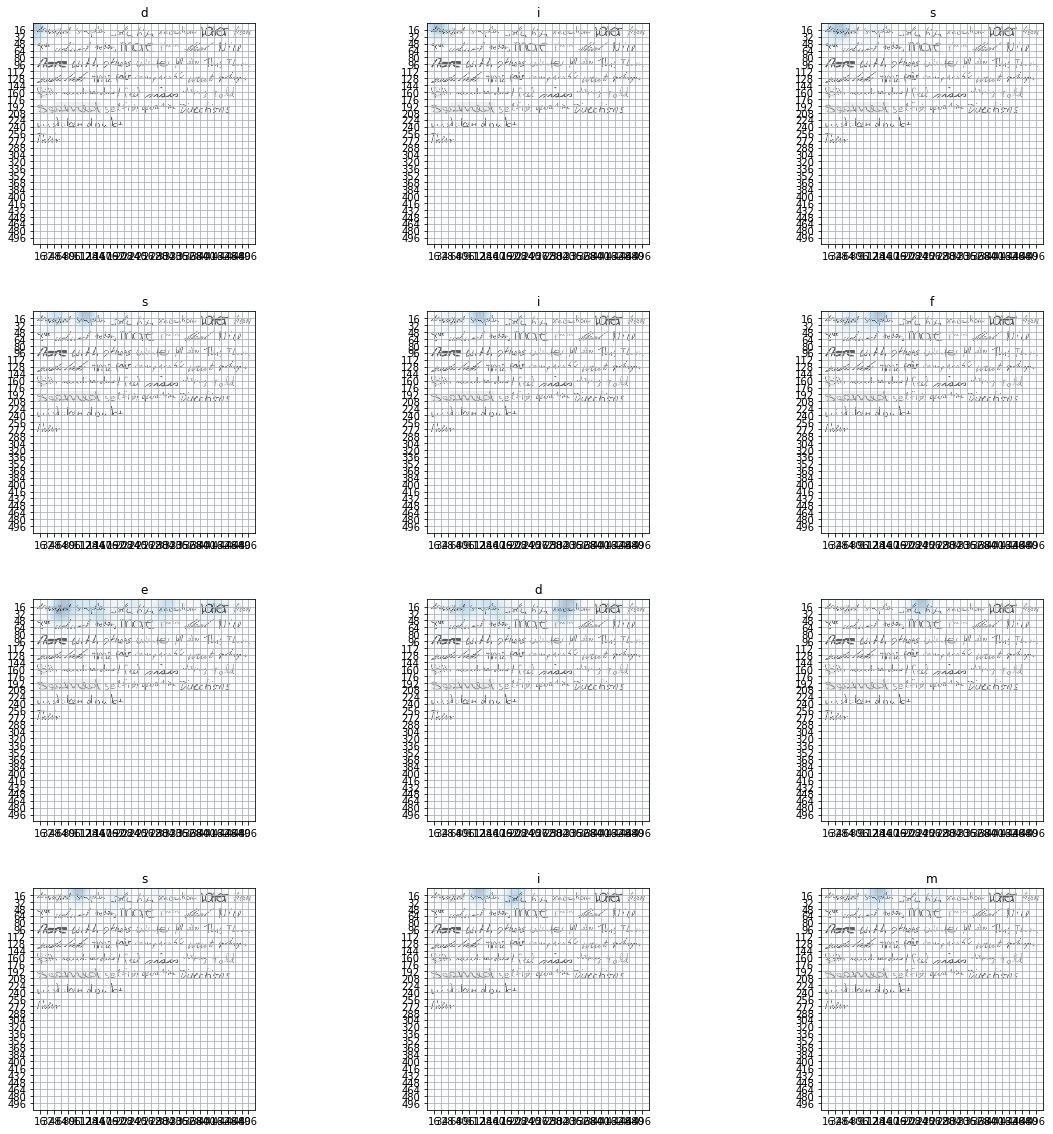

In [198]:
img = imgs[0]
fig, axes = plt.subplots(4,3, gridspec_kw={'hspace': 0.3}, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
    a = g_filter(img_attns[i])
    ax.imshow(img, alpha=None)
    ax.imshow(a, cmap='Blues', alpha=0.3)
    
    # Attention
    ticks = np.arange(k, sz, k)
    ax.set_yticks(ticks, minor=False)
    ax.set_xticks(ticks, minor=False)
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)

    ax.set_title(itos[pred[i].item()])

### Experiments with topk and thresholding attn

In [86]:
learn.model.img_enc

ResnetBase(
  (base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (

In [76]:
# top 4 attn values
values,idxs = src_attn.topk(4)
dist = torch.zeros_like(src_attn)
dist.scatter_(-1, idxs, values)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [193]:
# threshold above 0.2 attn values
dist = F.threshold(src_attn, 0.2, 0)

In [77]:
img_attns = to_np(torch_scale_attns(dist)[0])

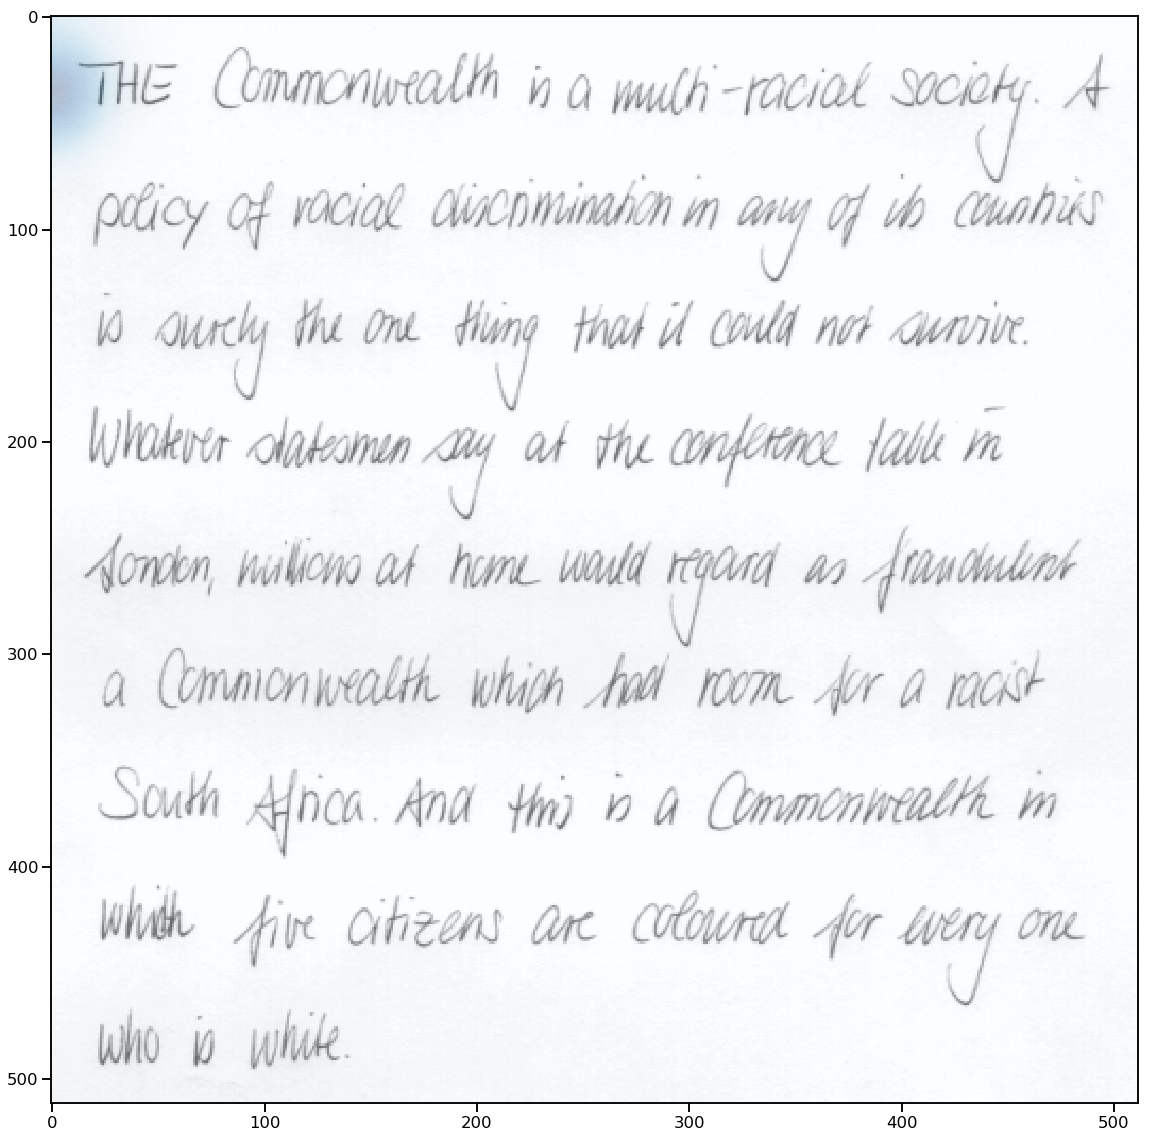

In [109]:
ax = show_img(img, figsize=(20,20))
for i in range(1):   #len(img_attns)
    a = g_filter(img_attns[i])
    ax.imshow(a, cmap='Blues', alpha=0.3)

# PositionalEncoding2d Experimentation

In [62]:
class ResnetBase(nn.Module):
    def __init__(self, em_sz, d_model):
        super().__init__()
        
        slices = {128: -4, 256: -3, 512: -2}
        s = slices[em_sz]
        net = f(True)
        modules = list(net.children())[:s]
        self.base = nn.Sequential(*modules)
        self.conv = nn.Conv2d(em_sz, d_model, 1)
#         self.pos_enc = PositionalEncoding2d(d_model, dims=2, dropout=0.2)     #sinusoidal
#         self.pos_enc = PositionalEmbedding2d(d_model, dims=2, dropout=0.2)

    def forward(self, img):
        x = self.base(img)
        x = self.conv(x).permute(0,2,3,1)
        x *= math.sqrt(x.size(-1))
        return x.flatten(1,2).contiguous()   #self.pos_enc(x)        # bs,h*w,d_model

In [40]:
class PositionalEncoding2d(nn.Module):
    "Implement the PE function for multiple dimensions"
    def __init__(self, d_model, dims=1, dropout=0.1, max_len=2000):
        super(PositionalEncoding2d, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.dims = dims
        
        channels = d_model//dims
        pe = torch.zeros(max_len, channels)
        position = torch.arange(0.0, max_len).unsqueeze(1)
        log_increment = math.log(1e4) / channels
        div_term = torch.exp(torch.arange(0.0, channels, 2) * -log_increment)  
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe.unsqueeze_(0)
        if dims==2:
            w_pe = F.pad(pe, (0,channels)).unsqueeze(2)
            h_pe = F.pad(pe, (channels,0)).unsqueeze(1)
            pe = w_pe + h_pe
        if dims>2:
            raise NotImplementedError("More than 2 dimensional PE is not implemented")
        self.register_buffer('pe', pe)    #(1,max_len,max_len,d_model)
        
    def forward(self, x):
        # 1d: ([bs, sl, d_model])
        # 2d: ([bs, h, w, d_model])
        if self.dims == 1:
            x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        else:
            x = x + Variable(self.pe[:, :x.size(1), :x.size(2)], requires_grad=False)
            x = x.flatten(1,2).contiguous()
        return self.dropout(x)

In [58]:
class PositionalEmbedding2d(nn.Module):
    "Implement a PE function for multiple dimensions"
    def __init__(self, d_model, dims=1, dropout=0.1, max_len=2000):
        super(PositionalEmbedding2d, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.dims = dims
        d = (sz//8) if device.type == 'cpu' else (sz//16)   # specific to base
        
        self.channels = d_model//dims
        self.emb = nn.Embedding(max_len, self.channels)

        data = np.tile(np.array(range(d)),(1,1))      
        self.data = torch.tensor(data, dtype=torch.long, device=device)
        
    def forward(self, x):        
        pe = self.emb(self.data)
        if self.dims == 1:
            x = x + Variable(pe[:, :x.size(1)], requires_grad=False)
        if self.dims==2:
            w_pe = F.pad(pe, (0,self.channels)).unsqueeze(2)
            h_pe = F.pad(pe, (self.channels,0)).unsqueeze(1)
            pe = w_pe + h_pe
            x = x + Variable(pe[:, :x.size(1), :x.size(2)], requires_grad=False)
            x = x.flatten(1,2).contiguous()
        
        return self.dropout(x)